## Computer Vision Lecture-9 GAN (Spring 2021)

Instructors: Muhammad Fahim, Riby A. B.

Acknowledgement
This lab was maintained by Riby A. B., Rufina, Alex and Fahim


In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
# remove grid lines
import numpy as np
import cv2
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# helper functions
def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
      
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

## GAN
![alt text](https://miro.medium.com/max/2832/1*6zMZBE6xtgGUVqkaLTBaJQ.png)

In [3]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])#check https://pytorch.org/docs/stable/torchvision/transforms.html

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)#check https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)# check https://pytorch.org/docs/stable/data.html
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...


Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)# https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)#check https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [5]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [6]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [7]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
# loss
criterion = nn.BCELoss()# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)# https://pytorch.org/docs/stable/optim.html
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [9]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backpropagation & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [10]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [11]:
n_epoch = 10
save_every = 1
mkdir('weights')

for epoch in tqdm(range(1, n_epoch+1), desc="Epochs"):           
    D_losses, G_losses = [], []
    
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
    
    print(G.state_dict())
    
    torch.save(G.state_dict(), "weights/G_{:03d}.pth".format(epoch))
    torch.save(D.state_dict(), "weights/D_{:03d}.pth".format(epoch))
    # for load
    # G.load_state_dict(torch.load(path))
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

print('We are done')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


OrderedDict([('fc1.weight', tensor([[-0.0093,  0.0057,  0.0684,  ..., -0.0505, -0.0123,  0.0002],
        [-0.0556, -0.0313,  0.0266,  ...,  0.0034,  0.0390,  0.0073],
        [ 0.0289, -0.0545,  0.0612,  ...,  0.0223, -0.0088, -0.0705],
        ...,
        [-0.0123,  0.0340,  0.0208,  ...,  0.0515, -0.0049,  0.0052],
        [-0.0565, -0.0329,  0.0169,  ..., -0.0334, -0.0509,  0.0515],
        [ 0.0276, -0.0104,  0.0289,  ...,  0.0428, -0.0116,  0.0366]],
       device='cuda:0')), ('fc1.bias', tensor([-2.6804e-02, -2.4233e-02, -9.7834e-02, -2.7221e-02, -8.4152e-02,
        -1.6210e-01, -1.4548e-01, -1.6106e-02, -1.0662e-01, -3.8685e-02,
        -4.4063e-02, -1.2903e-01, -1.0562e-01, -6.8278e-02, -7.7030e-02,
        -7.9029e-02, -6.9390e-02, -9.7033e-02, -9.3096e-02, -7.0499e-02,
         8.3081e-03, -1.1620e-01, -1.3221e-01, -2.0806e-02, -2.1769e-03,
        -1.4522e-01, -2.0559e-03, -8.4272e-03, -1.2069e-01,  1.3698e-03,
         3.2318e-02, -1.0912e-01,  2.3501e-02, -5.3201e-02, -

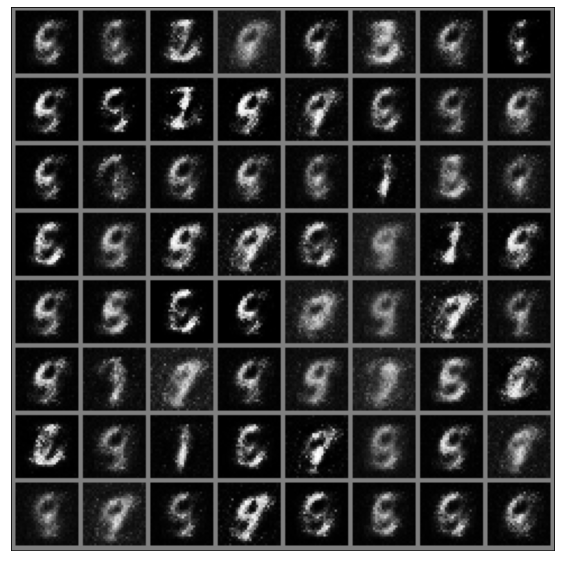

In [12]:
def show_generator_results(batch_vectors: np.array):
  with torch.no_grad():
    test_z = Variable(torch.Tensor(batch_vectors).to(device))
    generated = G(test_z)
        
    grid = make_grid(generated.view(generated.size(0), 1, 28, 28)).cpu().numpy()[0]
    show_in_row([grid], disable_ticks=True)
    

show_generator_results(np.random.rand(64, z_dim) * 2 - 1)

In [16]:
def generate_changing_vec(examples_count: int, vec_len: int) -> np.array:
    # return np.array of shape (examples_count, vec_len)
    vec1 = np.random.rand(1, vec_len)*2-1
    vec2 = np.random.rand(1, vec_len)*2-1
    
    # perform interpolation between vecs
    steps = examples_count
    # everything below TODO
    diff_vec = vec2 - vec1
    step = np.divide(diff_vec,steps)
    interpolated_vec = vec1
    list_interpeolated_vec = np.array(vec1)
    for i in range(steps - 1 ):
      interpolated_vec = interpolated_vec + step
      list_interpeolated_vec = np.append(list_interpeolated_vec, interpolated_vec, axis=0)
    
    return list_interpeolated_vec


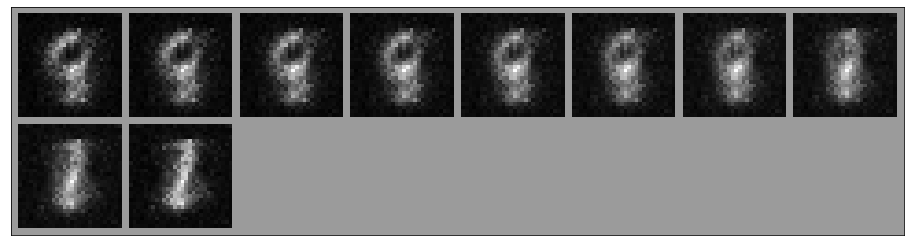

In [42]:
a = generate_changing_vec(10, 100)

with torch.no_grad():
  t = Variable(torch.Tensor(a).to(device))
  generated = G(t)

  grid = make_grid(generated.view(generated.size(0), 1, 28, 28)).cpu().numpy()[0]
  show_in_row([grid], disable_ticks=True)

## References
1. Pytorch introduction: https://pytorch.org/tutorials/
2.  Tensor introduction: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py}\
3. MNIST dataset: http://yann.lecun.com/exdb/mnist/
4. GAN for MNIST dataset: https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60
5. Neural Network using PyTorch: https://pytorch.org/tutorials/beginner/nn_tutorial.html
